In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Access data

In [ ]:
file = open('4U_Reviews.txt', 'r', errors='ignore')
datalines = file.readlines()
print(f"There are {len(datalines)} lines in the file.\n")
print("The first 30 lines are:\n")
for i in range(30):
    print(datalines[i:i+1])

There are 1372 lines in the file.

The first 30 lines are:

['"they have been unresponsive"\n']
['Brian McNamee (Canada) 16th October 2015\n']
['2\n']
['We flew with Germanwings (or tried to) on September 30th. After two lengthy delays passengers were notified that the flight was cancelled and to return to the check-in counter for further information. After waiting at the counter for another 30 minutes or so, staff began issuing refunds or providing alternate travel options to passengers. By this point it was quite late in the evening with limited options (plus we were 5+ hours after planned departure). We managed to get a voucher with 3 other passenger to get a flight from Stuttgart to Zurich with an ongoing connection to Amsterdam (flights were with Swiss). We made the flight and the connector (which was held back waiting for about 70 of us) however luggage did not make it. Short of this is the airline was ill-prepared to manage this. They offered little information or options to pas

After looking through the file briefly, one will find that the data file contains different comments from passengers of different flights. 

It is also found that these comment have different schemas, but they also share a few things in common:

- The following fields are avilabale for all comments:
    - Review heading (a short phrase)
    - Reviewer information
        - All comments specify the reviewer's name and the review date
        - Sometimes the reviewer's country is also included
    - Rating of the flight (from 1 to 10)
    - Review text
    - Whether the passenger recommends the flight or not (either "yes" or "no")
- The following fields are not always available:
    - Aircraft label
    - Type of traveller (purpose of taking the flight)
    - Cabin flown
    - Route of flight
    - Date of flight
    - Detailed rating components:
        - Seat comfort
        - Cabin staff service
        - Food and beverages
        - Inflight entertainment
        - Wifi and connectivity
        - Ground service
        - Value for money

With the information above, the raw data can be converted into a table format for better analysis.

# Convert into table format
## Setup: define data schema

In [ ]:
unnamed_cols = {'Heading': [], 
                'Reviewer Info': [], 
                'Rating': [], 
                'Review': []}

reviewer_info = {'Reviewer Name': [],
                 'Country': [], 
                 'Date': [], }

named_cols = {'Aircraft': [], 
              'Type Of Traveller': [], 
              'Cabin Flown': [], 
              'Route': [], 
              'Date Flown': [], 
              'Seat Comfort': [], 
              'Cabin Staff Service': [], 
              'Food & Beverages': [], 
              'Inflight Entertainment': [], 
              'Wifi & Connectivity': [],
              'Ground Service': [], 
              'Value For Money': [], 
              'Recommended': []}

## Find the common separator between consecutive reviews
From the data file, candidates for being the separator between reviews include the blank lines and the line with the "Recommended" value

In [ ]:
print("The number of blank lines in the file is", len([l for l in datalines if l=="\n"]))
print('The number of lines with the "Recommended" value is', len([l for l in datalines if "Recommended\t" in l]))

The number of blank lines in the file is 127
The number of lines with the "Recommended" value is 128


The two numbers above prove that the hypothesis about the separator candidates is true: there are a total of 128 lines, therefore 127 blank lines are in between.

In [ ]:
# Find out the indices of the blank lines and concatenate the beginning and ending points
# to help better split them into different review segments
review_split_idxs = np.concatenate(([-1], np.where(np.array(datalines)=="\n"), [len(datalines)]), axis=None)

for i in range(len(review_split_idxs)-1):
    idx_start = review_split_idxs[i]
    idx_end = review_split_idxs[i+1]
    review_data = datalines[idx_start+1:idx_end]
    
    # Extract and fill in the information available in all comments
    for j in range(len(unnamed_cols)):
        col = list(unnamed_cols.keys())[j]
        unnamed_cols[col].append(review_data[j].replace("\n", "").replace('"', ''))
    
    # Extract and fill in the available field values of each rating component
    rating_items = list(named_cols.keys())
    rating_items.remove("Recommended")
    for d in review_data[j+1:-1]:
        d = d.replace("\n", "")
        clean_name = d.split("\t")[0]
        if clean_name is not None:
            if clean_name in rating_items:
                rating_items.remove(clean_name)
                named_cols[clean_name].append(d.split("\t")[1])
    
    # For the remaining rating components which are not available, fill in NaNs
    if len(rating_items)>0:
        for r in rating_items:
            named_cols[r].append(np.nan)
    named_cols["Recommended"].append(review_data[-1].replace('\n', '').split('\t')[1])
    
# Further extract name, (country,) and date information from the "Reviewer Info" line
for c in unnamed_cols["Reviewer Info"]:
    try:
        split_start = c.index("(")
        split_end = c.index(")")
        reviewer_info['Reviewer Name'].append(c[:split_start-1])
        reviewer_info['Country'].append(c[split_start+1:split_end])
        reviewer_info['Date'].append(c[split_end+2:])
    except:
        number_idx = re.search(r"\d", c).start()
        reviewer_info['Reviewer Name'].append(c[:number_idx-1])
        reviewer_info['Country'].append(np.nan)
        reviewer_info['Date'].append(c[number_idx:])
del unnamed_cols["Reviewer Info"]

## Overview of the resulting dataframe

In [ ]:
data = {**unnamed_cols, **reviewer_info, **named_cols}
review_df = pd.DataFrame.from_dict(data)

display(review_df.head())
display(review_df.describe())

,Heading,Rating,Review,Reviewer Name,Country,Date,Aircraft,Type Of Traveller,Cabin Flown,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Wifi & Connectivity,Ground Service,Value For Money,Recommended
0,they have been unresponsive,2,We flew with Germanwings (or tried to) on Sept...,Brian McNamee,Canada,16th October 2015,NaN,Couple Leisure,Economy,Stuttgart to Amsterdam,September 2015,12345,12345,NaN,NaN,NaN,12345,12345,no
1,I was refused some water,3,I am less than impressed with Germanwings serv...,L Mouratidou,United Kingdom,4th October 2015,NaN,Solo Leisure,Economy,Hamburg to London,September 2015,12345,12345,NaN,NaN,NaN,12345,12345,no
2,the service crew were friendly but nothing more,3,Flew from Palma de Mallorca to Cologne with Ge...,H Mutschler,Germany,21st September 2015,A319-100,Couple Leisure,Economy,PMI to CGN,September 2015,12345,12345,12345,12345,NaN,12345,12345,no
3,"no problems or delays, very friendly staff",10,Good flight from Berlin-Tegel to London Heathr...,Oliver Numrich,Germany,20th September 2015,NaN,Business,NaN,Berlin-Tegel to London Heathrow,August 2015,12345,12345,12345,12345,12345,12345,12345,yes
4,I don't get why Germanwings is always late,4,I don't get why Germanwings is always late and...,Andreas Huettenhoelscher,Germany,14th September 2015,NaN,Business,Economy,CGN to LHR,September 2015,12345,12345,12345,NaN,NaN,12345,12345,no


,Heading,Rating,Review,Reviewer Name,Country,Date,Aircraft,Type Of Traveller,Cabin Flown,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Wifi & Connectivity,Ground Service,Value For Money,Recommended
count,128,128,128,128,115,128,4,14,114,14,14,81,81,78,72,4,14,115,128
unique,10,11,128,110,15,118,3,4,2,14,5,2,2,2,2,1,1,2,2
top,Germanwings customer review,4,Flew out of LHR to Cologne. As the strike was ...,H Mutschler,United Kingdom,4th August 2013,A320,Business,Economy,Hamburg to Paris,September 2015,12345,12345,12345,N/A,12345,12345,12345,no
freq,119,15,1,11,44,2,2,5,113,1,6,78,78,61,39,4,14,114,66


# Data cleaning and exploratory analysis by column
## Long-string columns: `Heading` and `Review`
Most of the contents of the "Heading" column is the phrase "Germanwings customer review" which does not mean anything. Therefore, this phrase will be removed from the "Heading" field of all rows, and the remaining contents of the "Heading" column will be combined into the "Review" column.

In [ ]:
print(review_df.Heading.value_counts())

Germanwings customer review                        119
staff friendly - food terrible                       1
vowing never to book Germanwings again               1
no problems or delays, very friendly staff           1
I don't get why Germanwings is always late           1
they have been unresponsive                          1
the service crew were friendly but nothing more      1
no explanations, no offers of help                   1
delay in Heathrow about 1:30 minutes                 1
I was refused some water                             1
Name: Heading, dtype: int64


In [ ]:
review_df['Review'] = review_df.apply(lambda row: row.Heading + ". " + row.Review if 
                                      row.Heading!='Germanwings customer review' else row.Review,
                                      axis=1)
review_df = review_df.drop("Heading", axis=1)

count    128.000000
mean     101.929688
std       48.678146
min       20.000000
25%       68.000000
50%       93.500000
75%      133.000000
max      251.000000
Name: Review_len, dtype: float64


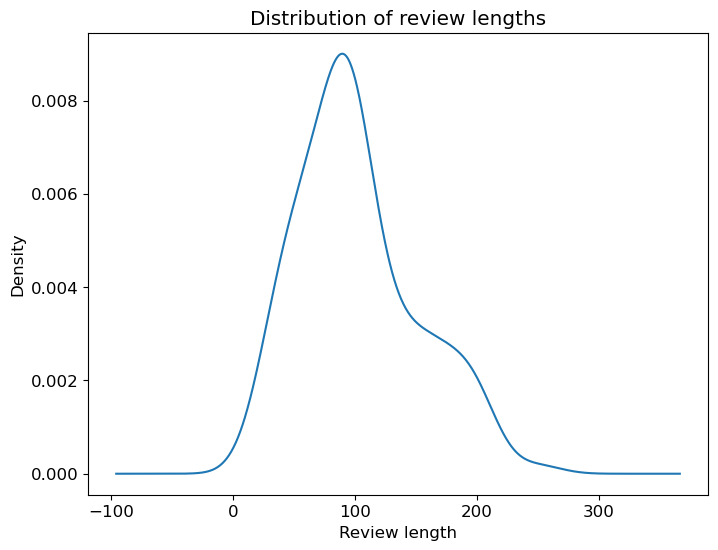

In [ ]:
# Add descriptive column for review
review_df['Review_len'] = review_df.apply(lambda row: len(row.Review.split(" ")), axis=1)
print(review_df.Review_len.describe())

review_df.Review_len.plot.kde()
plt.xlabel("Review length")
plt.title("Distribution of review lengths")

# plt.savefig("Review_len_dist.png", pad_inches=0.05, dpi=1000)
plt.show()

## `Rating`

In [ ]:
print(review_df.Rating)

0       2
1       3
2       3
3      10
4       4
       ..
123     4
124     4
125     3
126     1
127     3
Name: Rating, Length: 128, dtype: object


count    115.000000
mean       5.565217
std        2.871916
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: Rating, dtype: float64


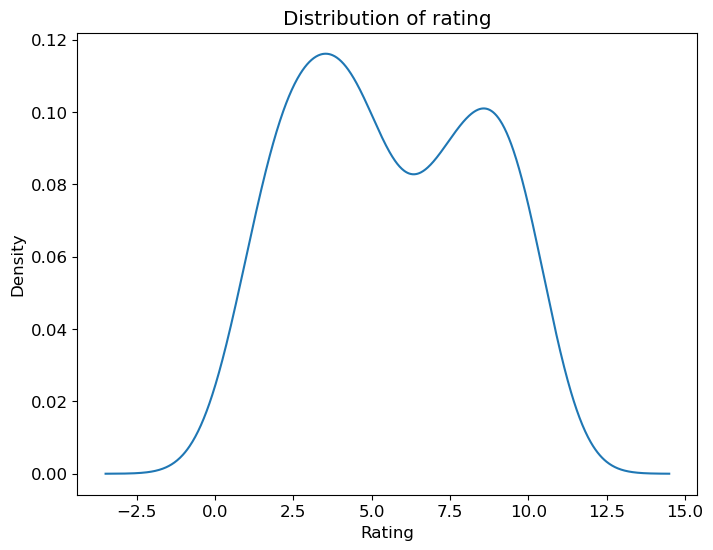

In [ ]:
# Convert column type
review_df['Rating'] = pd.to_numeric(review_df['Rating'], errors='coerce')
print(review_df.Rating.describe())

review_df.Rating.plot.kde()
plt.xlabel("Rating")
plt.title("Distribution of rating")

# plt.savefig("Rating_dist.png", pad_inches=0.05, dpi=1000)
plt.show()

## `Country`

In [ ]:
print(review_df.Country.value_counts())

United Kingdom    44
Germany           43
Netherlands        7
United States      5
Czech Republic     3
Canada             2
Italy              2
Austria            2
Australia          1
Croatia            1
Finland            1
France             1
Gibraltar          1
China              1
Ireland            1
Name: Country, dtype: int64


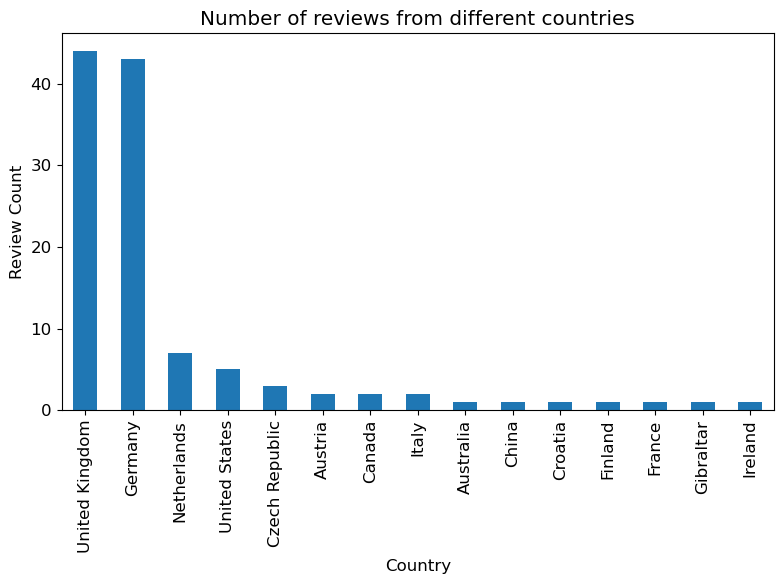

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 12})

country_pivot = pd.pivot_table(review_df, values='Review', index='Country', aggfunc='count')
country_pivot.sort_values('Review', ascending=False).plot.bar()
plt.ylabel('Review Count')
plt.title("Number of reviews from different countries")
plt.legend('',frameon=False)

plt.tight_layout()
# plt.savefig("Review_count_country.png", pad_inches=0.05, dpi=1000)
plt.show()

## Date columns: `Date` and `Date Flown`

In [ ]:
review_df.Date

0        16th October 2015
1         4th October 2015
2      21st September 2015
3      20th September 2015
4      14th September 2015
              ...         
123       28th August 2008
124       18th August 2008
125         18th June 2008
126        28th April 2008
127        28th April 2008
Name: Date, Length: 128, dtype: object

In [ ]:
review_df['Date Flown']

0      September 2015
1      September 2015
2      September 2015
3         August 2015
4      September 2015
            ...      
123               NaN
124               NaN
125               NaN
126               NaN
127               NaN
Name: Date Flown, Length: 128, dtype: object

In [ ]:
# Convert to datetime format
review_df['Review Date'] = 0
review_df["Flight Date"] = 0

months = ["January", "Febuary", "March", "April", "May", "June", "July",
          "August", "September", "October", "November", "December"]

for idx, row in review_df.iterrows():
    r_date = review_df.at[idx, "Date"]
    r_date = r_date.replace("th", "").replace("nd", "").replace("rd","").replace("st","")
    month_old = "".join([c for c in r_date if c.isdigit()==False]).replace(" ", "")
    if month_old not in months:
        for m in months:
            if month_old in m:
                month_new = m
                r_date = r_date.replace(month_old, month_new)
    review_df.at[idx, 'Review Date'] = datetime.strptime(r_date, '%d %B %Y')
    
    f_date = review_df.at[idx, "Date Flown"]
    try:
        review_df.at[idx, 'Flight Date'] = datetime.strptime(f_date, '%B %Y')
    except:
        review_df.at[idx, 'Flight Date'] = pd.NaT
    
review_df['Review Date'] = pd.to_datetime(review_df['Review Date'])
review_df['Flight Date'] = pd.to_datetime(review_df['Flight Date'])
review_df = review_df.drop(["Date", "Date Flown"], axis=1)

review_df['Review Date'], review_df['Flight Date']

(0     2015-10-16
 1     2015-10-04
 2     2015-09-21
 3     2015-09-20
 4     2015-09-14
          ...    
 123   2008-08-28
 124   2008-08-18
 125   2008-06-18
 126   2008-04-28
 127   2008-04-28
 Name: Review Date, Length: 128, dtype: datetime64[ns],
 0     2015-09-01
 1     2015-09-01
 2     2015-09-01
 3     2015-08-01
 4     2015-09-01
          ...    
 123          NaT
 124          NaT
 125          NaT
 126          NaT
 127          NaT
 Name: Flight Date, Length: 128, dtype: datetime64[ns])

## `Cabin Flown`

In [ ]:
print(review_df['Cabin Flown'].value_counts())

Economy        113
First Class      1
Name: Cabin Flown, dtype: int64


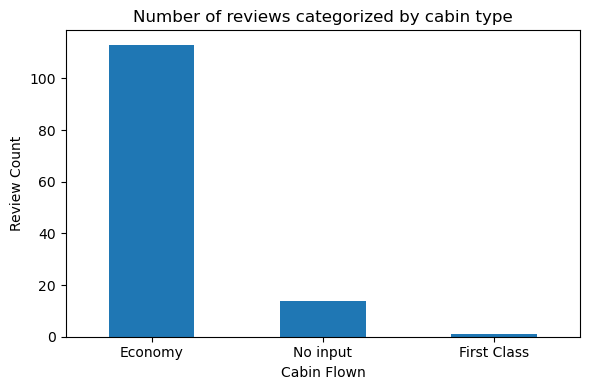

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams.update({'font.size': 10})

cabin_pivot = review_df.copy()
cabin_pivot['Cabin Flown'] = review_df['Cabin Flown'].fillna("No input")
cabin_pivot = pd.pivot_table(cabin_pivot, values='Review', index='Cabin Flown', aggfunc='count')

cabin_pivot.sort_values('Review', ascending=False).plot.bar(rot=0)
plt.ylabel('Review Count')
plt.title("Number of reviews categorized by cabin type")
plt.legend('',frameon=False)

plt.tight_layout()
# plt.savefig("Review_count_cabin.png", pad_inches=0.05, dpi=1000)
plt.show()

Most of the traverllers flew in the Economy cabin.

## Flight-info columns that have many NaN values: `Aircraft`, `Type Of Traveller`, `Route`, and `Flight Date`

In [ ]:
print(review_df['Aircraft'].value_counts())
print("\n")
print(review_df['Type Of Traveller'].value_counts())
print("\n")
print(review_df['Route'].value_counts())
print("\n")
print(review_df['Flight Date'].value_counts())

A320        2
A319-100    1
A319        1
Name: Aircraft, dtype: int64


Business          5
Couple Leisure    5
Solo Leisure      2
FamilyLeisure     2
Name: Type Of Traveller, dtype: int64


Hamburg to Paris                   1
Istanbul to London via DUS         1
Stansted to Cologne                1
CGN to LHR                         1
FCO to TXL                         1
Düsseldorf to London               1
Duesseldorf to Heathrow            1
Berlin-Tegel to London Heathrow    1
Cologne to Palma                   1
Hamburg to Geneva                  1
Stuttgart to Amsterdam             1
Hamburg to London                  1
Dusseldorf to Heathrow             1
PMI to CGN                         1
Name: Route, dtype: int64


2015-09-01    6
2015-08-01    4
2015-07-01    2
2015-06-01    1
2015-05-01    1
Name: Flight Date, dtype: int64


In [ ]:
review_df.loc[(~review_df['Aircraft'].isna()) | 
              (~review_df['Type Of Traveller'].isna()) | 
              (~review_df['Route'].isna()) | 
              (~review_df['Flight Date'].isna())][['Aircraft',
                                                   'Type Of Traveller',
                                                   'Route', 'Flight Date',
                                                   'Rating']]

,Aircraft,Type Of Traveller,Route,Flight Date,Rating
0,NaN,Couple Leisure,Stuttgart to Amsterdam,2015-09-01,2.0
1,NaN,Solo Leisure,Hamburg to London,2015-09-01,3.0
2,A319-100,Couple Leisure,PMI to CGN,2015-09-01,3.0
3,NaN,Business,Berlin-Tegel to London Heathrow,2015-08-01,10.0
4,NaN,Business,CGN to LHR,2015-09-01,4.0
5,NaN,Couple Leisure,Istanbul to London via DUS,2015-09-01,1.0
6,NaN,Solo Leisure,Düsseldorf to London,2015-08-01,7.0
7,NaN,FamilyLeisure,Dusseldorf to Heathrow,2015-09-01,2.0
8,A320,Business,Duesseldorf to Heathrow,2015-07-01,2.0
9,NaN,Couple Leisure,Cologne to Palma,2015-08-01,5.0


In [ ]:
review_df.loc[(~review_df.Aircraft.isna()) | 
              (~review_df['Type Of Traveller'].isna()) | 
              (~review_df['Route'].isna())].Rating.value_counts()

2.0     5
3.0     2
10.0    2
1.0     2
7.0     1
4.0     1
5.0     1
Name: Rating, dtype: int64

Observation: The people who provide the information of these columns are in the same group. Most of them give relatively extreme rating values.

While these columns are not likely to be used in modelling or descriptive analysis given the small number of non-NaN values, their contents indicate potential improvement in the data recording system:

Only 4 passengers provided the aircraft information, and 14 passengers provided their route information. Moreover, the specific values are not consistent: for example, some passengers input airport names while some input city names, and some would input both. Even if all passengers provide this information, it can be difficult to standardize and clean the data. It is also understandable that most passengers did not provide the information, given that it would take them extra time to find the information and they are unlikely to be motivated to do so. This can be improved by automatically linking each comment to each flight experience, so that when customers agree to leave a comment for a certain flight, the flight information will already been prefilled.

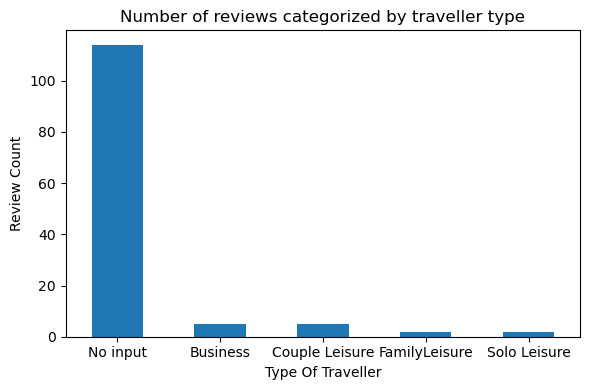

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams.update({'font.size': 10})

type_pivot = review_df.copy()
type_pivot['Type Of Traveller'] = review_df['Type Of Traveller'].fillna("No input")
type_pivot = pd.pivot_table(type_pivot, values='Review', index='Type Of Traveller', aggfunc='count')

type_pivot.sort_values('Review', ascending=False).plot.bar(rot=0)
plt.ylabel('Review Count')
plt.title("Number of reviews categorized by traveller type")
plt.legend('',frameon=False)

plt.tight_layout()
# plt.savefig("Review_count_type.png", pad_inches=0.05, dpi=1000)
plt.show()

## Rating items: `Seat Comfort`, `Cabin Staff Service`, `Food & Beverages`, `Inflight Entertainment`, `Wifi & Connectivity`, `Ground Service`, `Value For Money`

In [ ]:
print(review_df['Seat Comfort'].value_counts())
print("\n")
print(review_df['Cabin Staff Service'].value_counts())
print("\n")
print(review_df['Food & Beverages'].value_counts())
print("\n")
print(review_df['Inflight Entertainment'].value_counts())
print("\n")
print(review_df['Wifi & Connectivity'].value_counts())
print("\n")
print(review_df['Ground Service'].value_counts())
print("\n")
print(review_df['Value For Money'].value_counts())
print("\n")

12345    78
N/A       3
Name: Seat Comfort, dtype: int64


12345    78
N/A       3
Name: Cabin Staff Service, dtype: int64


12345    61
N/A      17
Name: Food & Beverages, dtype: int64


N/A      39
12345    33
Name: Inflight Entertainment, dtype: int64


12345    4
Name: Wifi & Connectivity, dtype: int64


12345    14
Name: Ground Service, dtype: int64


12345    114
N/A        1
Name: Value For Money, dtype: int64




- The numbers of values for these columns are relatively low.
- Inconsistency in rating standards: the rating items provided to all customers are not the same. For example, customer A might be asked to rate Wifi & Connectivity while customer B is not.
- Data provided cannot reveal the true level of the rating since the only value is "12345". This might be because of how the rating data is extracted from the rating system: instead of capturing the specific value of the rating, the entire rating scale is exported. As a result, these columns cannot be used for further analysis or modelling.

In [ ]:
review_df = review_df.drop(['Seat Comfort', 'Cabin Staff Service', 
                            'Food & Beverages', 'Inflight Entertainment',
                            'Wifi & Connectivity', 'Ground Service', 
                            'Value For Money', 'Aircraft', 'Type Of Traveller',
                            'Route', 'Flight Date'], axis=1)

## `Recommended`

In [ ]:
review_df['Recommended'].value_counts()

no     66
yes    62
Name: Recommended, dtype: int64

In [ ]:
# Remap the column values to binary labels
map_recommend = {"yes": 1, "no": 0}
review_df['Recommended'] = review_df['Recommended'].map(map_recommend)

review_df['Recommended'].value_counts()

0    66
1    62
Name: Recommended, dtype: int64

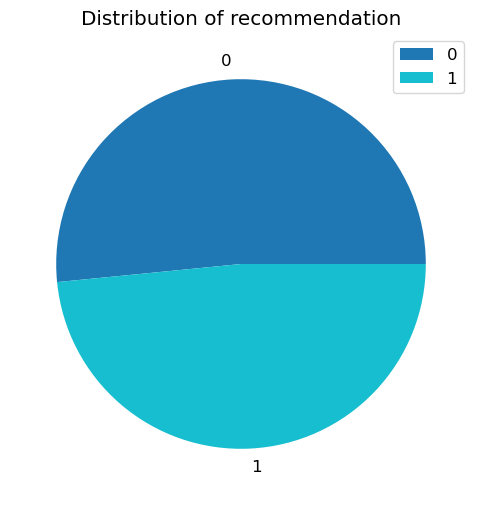

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 12})

recom_pivot = pd.pivot_table(review_df, index='Recommended', values='Review', aggfunc='count')
recom_pivot.plot.pie(y='Review', cmap='tab10')
plt.ylabel('')
plt.title("Distribution of recommendation")

# plt.savefig("Recommend_dist.png", pad_inches=0.05, dpi=1000)
plt.show()

# Relationship between columns
## Numerical columns

In [ ]:
review_df.describe()

,Rating,Recommended,Review_len
count,115.000000,128.000000,128.000000
mean,5.565217,0.484375,101.929688
std,2.871916,0.501719,48.678146
min,1.000000,0.000000,20.000000
25%,3.000000,0.000000,68.000000
50%,5.000000,0.000000,93.500000
75%,8.000000,1.000000,133.000000
max,10.000000,1.000000,251.000000


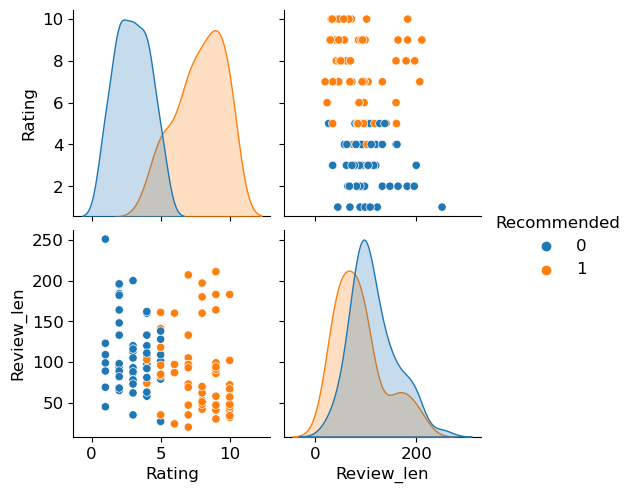

In [ ]:
sns.pairplot(review_df[['Rating', 'Review_len', "Recommended"]], hue="Recommended")
# plt.savefig("Pairplot.png", pad_inches=0.05, dpi=1000)
plt.show()

- From the 1st subplot (upper left), it can be seen that the detailed rating score and the value of `Recommended` is closly related to each other: people who recommend the flight has a rating distribution with a higher mean value, and vice versa.
- There does not seem to be a relationship between the review length and the rating score.
- The review lengths of passengers who do not recommend seem to be generally slightly longer than those of who recommend the flight.

### Dealing with NaN values in `Rating`
Since the rating score is closely related to whether the passenger recommends the flight or not, the NaN values in the `Rating` column can be filled by the average rating score within the same group.

In [ ]:
review_df.loc[review_df.Rating.isna()][['Rating', 'Recommended']]

,Rating,Recommended
31,NaN,0
33,NaN,0
45,NaN,0
48,NaN,0
51,NaN,0
53,NaN,0
67,NaN,0
75,NaN,0
79,NaN,0
109,NaN,0


In [ ]:
print("For passengers who do not recommend the flight, their average rating level"+
      f" is {round(review_df.loc[review_df.Recommended==0].Rating.mean(), 2)}")
print("For passengers who recommend the flight, their average rating level"+
      f" is {round(review_df.loc[review_df.Recommended==1].Rating.mean(), 2)}")

For passengers who do not recommend the flight, their average rating level is 2.94
For passengers who recommend the flight, their average rating level is 7.81


In [ ]:
review_df['Rating'] = review_df['Rating'].fillna(round(review_df.loc[review_df.Recommended==0].Rating.mean(), 2))

## Changes in ratings over time

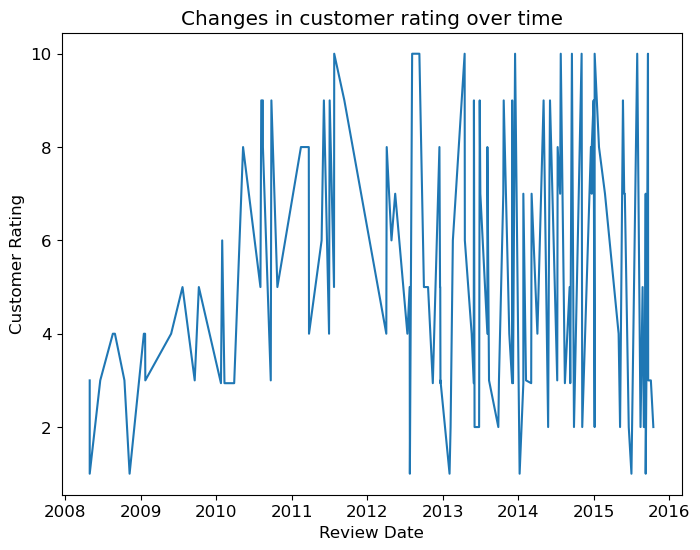

In [ ]:
# Overall rating changes over time
plt.plot(review_df['Review Date'], review_df['Rating'])

plt.xlabel("Review Date")
plt.ylabel("Customer Rating")
plt.title("Changes in customer rating over time")

# plt.savefig("Rating_change.png", pad_inches=0.05, dpi=1000)
plt.show()

From the plot above, an increasing trend in rating can be seen before 2012, after which the rating scores displayed higher fluctuations and no distinct trend can be observed.

### Changes in ratings by different countries

As shown above, most of the comments are made by customers from Germany and United Kingdom, and since the total number of reviews is relatively small (128 in total), the numbers of passengers from other countries make it difficult to observe patterns from their rating changes. Therefore, here, the country values are broadly classified into "Germany", "United Kingdom", and "Other".

In [ ]:
review_df['Country_group'] = review_df.apply(lambda row: row.Country if row.Country in ['Germany', 'United Kingdom']
                                             else "Other", axis=1)

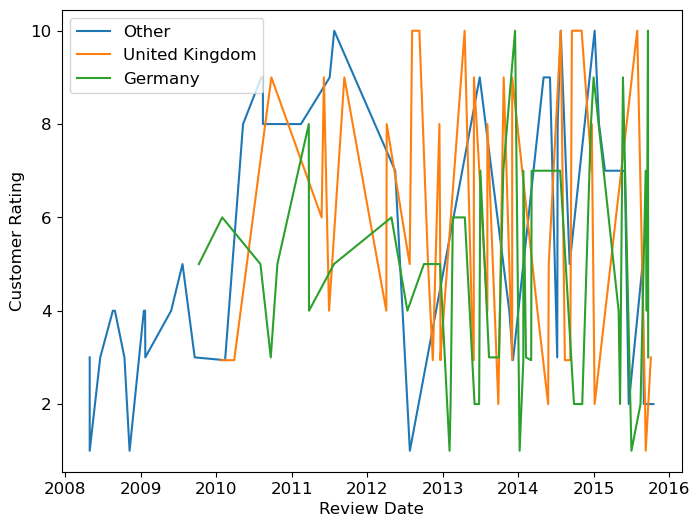

In [ ]:
for c in review_df['Country_group'].unique():
    plt.plot(review_df.loc[review_df.Country_group==c]['Review Date'], 
             review_df.loc[review_df.Country_group==c]['Rating'], label=c)

plt.xlabel("Review Date")
plt.ylabel("Customer Rating")
plt.legend()
plt.show()

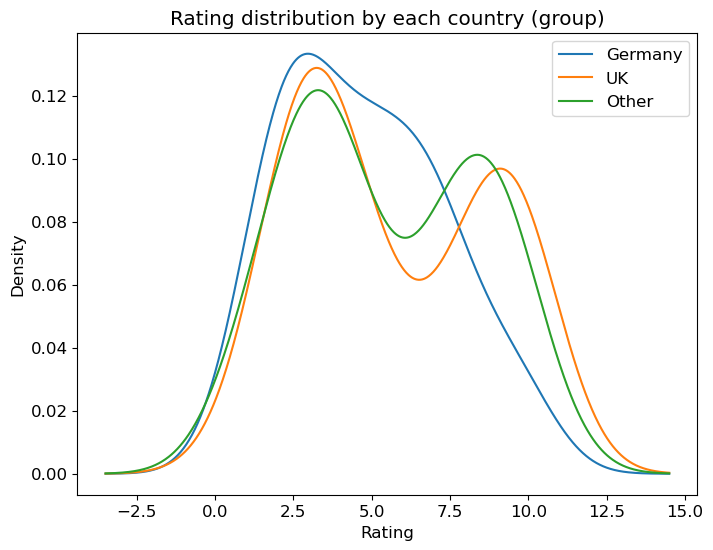

In [ ]:
review_df.loc[review_df.Country_group=="Germany"]['Rating'].plot.kde()
review_df.loc[review_df.Country_group=="United Kingdom"]['Rating'].plot.kde()
review_df.loc[review_df.Country_group=="Other"]['Rating'].plot.kde()

plt.legend(['Germany', 'UK', "Other"])
plt.xlabel("Rating")
plt.title("Rating distribution by each country (group)")
plt.savefig("Rating_dist_country.png", pad_inches=0.05, dpi=1000)
plt.show()

From the two plots above, it can be seen that:
- No distinct differences can be seen in each country group's rating changes over time
- The rating values from Germany are generally lower, while the rating distributions of passengers from UK and other countries are very similar to each other.

# Export
Next, to further explore the texts in the `Review` column, prediction and topic classification models will be built. Considering that the date values and country values do not seem to closely connect to the rating values or whether the passengers recommend the flights, they will not be used in the remaining steps.

In [ ]:
review_df = review_df[['Review', 'Rating', 'Recommended']]
review_df.to_csv("Clean_reviews.csv", index=False)

# Some further improvements

1. Some comments contain flight information regarding the airports/cities and also dates. However, the formats are not consistent (some mention cities some mention airports names/initials some mention all), and not all passengers do so.
    After extracting all possible flight-related information from the comments, further analysis can be performed regarding the relationship between different flight numbers and their ratings.
    
2. If the flight information is known for all passengers, other information can be linked to enrich the dataset: for example, the weather of that day, the occupancy rate of the flight (which is from internal database), etc.

3. If this is only a subset of the comment dataset, when looking at the complete version, one can also analyse the change of ratings from the same customer, and discover patterns regarding which factor might seem more important to a certain customer, based on which the company can provide more accurate recommendations for future flights or carry out more effective marketing campaigns.